# Interpreting Identity

# Setup
(No need to read)

In [1]:
TRAIN_MODEL = True

In [2]:
# Janky code to do different setup when run in a Colab notebook vs VSCode
import os

DEVELOPMENT_MODE = True
IN_GITHUB = os.getenv("GITHUB_ACTIONS") == "true"
# Upgrade pip
%pip install --upgrade pip
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")

    # PySvelte is an unmaintained visualization library, use it as a backup if circuitsvis isn't working
    # # Install another version of node that makes PySvelte work way faster
    # !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
    # %pip install git+https://github.com/neelnanda-io/PySvelte.git
except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")
    ipython.run_line_magic("pip", "install ipympl")
    ipython.run_line_magic("pip", "install scipy")
    ipython.run_line_magic("pip", "install manim")

if IN_COLAB or IN_GITHUB:
    %pip install transformer_lens
    %pip install circuitsvis
    %pip install ipympl

Note: you may need to restart the kernel to use updated packages.
Running as a Jupyter notebook - intended for development only!


/tmp/ipykernel_72258/863253725.py:24: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("load_ext autoreload")
/tmp/ipykernel_72258/863253725.py:25: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  ipython.magic("autoreload 2")


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio
if IN_COLAB or not DEVELOPMENT_MODE:
    pio.renderers.default = "colab"
else:
    pio.renderers.default = "notebook_connected"
print(f"Using renderer: {pio.renderers.default}")

Using renderer: notebook_connected


In [4]:
pio.templates['plotly'].layout.xaxis.title.font.size = 20
pio.templates['plotly'].layout.yaxis.title.font.size = 20
pio.templates['plotly'].layout.title.font.size = 30

In [5]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import os
import tqdm.auto as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

In [6]:
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache


device = "cuda" if torch.cuda.is_available() else "cpu"

Plotting helper functions:

In [7]:
def imshow(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def line(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.line(utils.to_numpy(tensor), labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

In [8]:
# Define the location to save the model, using a relative path
PTH_LOCATION = "workspace/_scratch/identity.pth"

# Create the directory if it does not exist
os.makedirs(Path(PTH_LOCATION).parent, exist_ok=True)

# Model Training

## Config

In [9]:
p = 3
frac_train = 1

# Optimizer config
lr = 1e-3
wd = 1e-2
betas = (0.9, 0.999)

num_epochs = 10000
checkpoint_every = 200

DATA_SEED = 598

## Define Task
* Define modular addition
* Define the dataset & labels

Input format:
|a|=|

In [10]:
a_vector = torch.arange(p)
equals_vector = einops.repeat(torch.tensor(p), " -> i", i=p)


In [11]:
dataset = torch.stack([a_vector, equals_vector], dim=1).to(device)
print(dataset)
print(dataset.shape)

tensor([[0, 3],
        [1, 3],
        [2, 3]], device='cuda:0')
torch.Size([3, 2])


In [12]:
labels = dataset[:, 0]
print(labels.shape)
print(labels)

torch.Size([3])
tensor([0, 1, 2], device='cuda:0')


Convert this to a train + test set - 30% in the training set

In [13]:
torch.manual_seed(DATA_SEED)
indices = torch.randperm(p)
cutoff = int(p*frac_train)
train_indices = indices[:cutoff]
test_indices = indices[cutoff:]

train_data = dataset[train_indices]
train_labels = labels[train_indices]
test_data = dataset[test_indices]
test_labels = labels[test_indices]
print(train_data)
print(train_labels)
print(train_data.shape)
print(test_data[:5])
print(test_labels[:5])
print(test_data.shape)

tensor([[2, 3],
        [0, 3],
        [1, 3]], device='cuda:0')
tensor([2, 0, 1], device='cuda:0')
torch.Size([3, 2])
tensor([], device='cuda:0', size=(0, 2), dtype=torch.int64)
tensor([], device='cuda:0', dtype=torch.int64)
torch.Size([0, 2])


## Define Model

In [14]:
cfg = HookedTransformerConfig(
    n_layers = 1,
    n_heads = 1,
    d_model = 2,
    d_head = 2,
    d_mlp = 0,
    act_fn = "relu",
    normalization_type=None,
    d_vocab=p+1,
    d_vocab_out=p,
    n_ctx=2,
    init_weights=True,
    device=device,
    seed = 995,
)
model = HookedTransformer(cfg)
for name, param in model.named_parameters():
    if "b_" in name:
        param.requires_grad = False

Disable the biases, as we don't need them for this task and it makes things easier to interpret.

## Define Optimizer + Loss

In [15]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd, betas=betas)
def loss_fn(logits, labels):
    if len(logits.shape)==3:
        logits = logits[:, -1]
    logits = logits.to(torch.float64)
    log_probs = logits.log_softmax(dim=-1)
    correct_log_probs = log_probs.gather(dim=-1, index=labels[:, None])[:, 0]
    return -correct_log_probs.mean()
train_logits = model(train_data)
train_loss = loss_fn(train_logits, train_labels)
print(train_loss)
test_logits = model(test_data)
test_loss = loss_fn(test_logits, test_labels)
print(test_loss)
print("Uniform loss:")
print(np.log(p))

tensor(1.0439, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward0>)
tensor(nan, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward0>)
Uniform loss:
1.0986122886681098


## Actually Train

**Weird Decision:** Training the model with full batch training rather than stochastic gradient descent. We do this so to make training smoother and reduce the number of slingshots.

In [30]:
train_losses = []
test_losses = []
model_checkpoints = []
checkpoint_epochs = []
if TRAIN_MODEL:
    for epoch in tqdm.tqdm(range(num_epochs)):
        train_logits = model(train_data)
        train_loss = loss_fn(train_logits, train_labels)
        train_loss.backward()
        train_losses.append(train_loss.item())

        optimizer.step()
        optimizer.zero_grad()

        with torch.inference_mode():
            test_logits = model(test_data)
            test_loss = loss_fn(test_logits, test_labels)
            test_losses.append(test_loss.item())

        if ((epoch+1)%checkpoint_every)==0:
            checkpoint_epochs.append(epoch)
            model_checkpoints.append(copy.deepcopy(model.state_dict()))
            # Extract the three 2-dimensional tensors
            vec1 = model.W_U.data[:, 0]
            vec2 = model.W_U.data[:, 1]
            vec3 = model.W_U.data[:, 2]

            # Function to compute the angle between two vectors
            def compute_angle(v1, v2):
                cos_theta = torch.dot(v1, v2) / (torch.norm(v1) * torch.norm(v2))
                angle = torch.acos(cos_theta) * (180.0 / np.pi)
                return angle

            # Compute pairwise angles
            angle_12 = compute_angle(vec1, vec2)
            angle_13 = compute_angle(vec1, vec3)
            angle_23 = compute_angle(vec2, vec3)

            print(f"Norms: {torch.norm(vec1)}, {torch.norm(vec2)}, {torch.norm(vec3)}")
            print(f"Angle between vec1 and vec2: {angle_12.item()} degrees")
            print(f"Angle between vec1 and vec3: {angle_13.item()} degrees")
            print(f"Angle between vec2 and vec3: {angle_23.item()} degrees")
            print(f"Epoch {epoch} Train Loss {train_loss.item()} Test Loss {test_loss.item()}")

  0%|          | 0/10000 [00:00<?, ?it/s]

Angle between vec1 and vec2: 105.95932006835938 degrees
Angle between vec1 and vec3: 125.59600830078125 degrees
Angle between vec2 and vec3: 128.44467163085938 degrees
Epoch 199 Train Loss 2.798575559248717e-06 Test Loss nan
Angle between vec1 and vec2: 106.10772705078125 degrees
Angle between vec1 and vec3: 125.4011001586914 degrees
Angle between vec2 and vec3: 128.49118041992188 degrees
Epoch 399 Train Loss 2.516201337201548e-06 Test Loss nan
Angle between vec1 and vec2: 106.2513427734375 degrees
Angle between vec1 and vec3: 125.2099380493164 degrees
Angle between vec2 and vec3: 128.53872680664062 degrees
Epoch 599 Train Loss 2.2687423418187778e-06 Test Loss nan
Angle between vec1 and vec2: 106.39028930664062 degrees
Angle between vec1 and vec3: 125.0225601196289 degrees
Angle between vec2 and vec3: 128.587158203125 degrees
Epoch 799 Train Loss 2.0517966085042963e-06 Test Loss nan
Angle between vec1 and vec2: 106.52416229248047 degrees
Angle between vec1 and vec3: 124.84009552001953 

In [17]:
if TRAIN_MODEL:
    torch.save(
        {
            "model":model.state_dict(),
            "config": model.cfg,
            "checkpoints": model_checkpoints,
            "checkpoint_epochs": checkpoint_epochs,
            "test_losses": test_losses,
            "train_losses": train_losses,
            "train_indices": train_indices,
            "test_indices": test_indices,
        },
        PTH_LOCATION)

In [18]:
if not TRAIN_MODEL:
    cached_data = torch.load(PTH_LOCATION)
    model.load_state_dict(cached_data['model'])
    model_checkpoints = cached_data["checkpoints"]
    checkpoint_epochs = cached_data["checkpoint_epochs"]
    test_losses = cached_data['test_losses']
    train_losses = cached_data['train_losses']
    train_indices = cached_data["train_indices"]
    test_indices = cached_data["test_indices"]

# Look at weights

## Embedding weights

In [19]:
from scipy.linalg import qr

print(model.embed.W_E.data)
print(model.embed.W_E.data.shape)

W_E = model.embed.W_E.data.cpu().numpy()
pos = model.W_E_pos.data.cpu().numpy()
for i in range(W_E.shape[0]):
    print(f"Norm of token {i}: {np.linalg.norm(W_E[i])}")
    index = (4 if i < 3 else 5)
    print(f"Embedding: {pos[index]}")
    W_E[i] += pos[index]


# Create a matrix with tensor[0] as the first column
ttr = W_E.transpose()
print(ttr)

# Perform QR decomposition to obtain an orthonormal matrix
Q, R = qr(ttr)

print("Q: ", Q)
print("R: ", R)
print(np.matmul(Q, R))

def get_angle(a, b):
    return np.arccos(
        np.dot(a, b)
        / (np.linalg.norm(a) * np.linalg.norm(b))
    ) / np.pi * 180

dot_product = np.dot(W_E[0], W_E[3])
print(dot_product, get_angle(W_E[0], W_E[3]))
product2 = np.dot(R[:, 0], R[:, 3])
print(product2, get_angle(R[:, 0], R[:, 3]))

tensor([[ 1.9919,  0.6364],
        [-1.7832,  2.1832],
        [-1.0393, -0.8866],
        [-1.0032, -0.0141]], device='cuda:0')
torch.Size([4, 2])
Norm of token 0: 2.0911331176757812
Embedding: [ 0.95460916 -0.90652376]
Norm of token 1: 2.8188352584838867
Embedding: [ 0.95460916 -0.90652376]
Norm of token 2: 1.36609947681427
Embedding: [ 0.95460916 -0.90652376]
Norm of token 3: 1.0033173561096191
Embedding: [-1.0607953   0.70485854]
[[ 2.9465358  -0.8285537  -0.08472562 -2.0640135 ]
 [-0.27007568  1.2766306  -1.7930963   0.6907403 ]]
Q:  [[-0.99582565  0.09127609]
 [ 0.09127609  0.99582565]]
R:  [[-2.9588873   0.9416208  -0.07929488  2.1184459 ]
 [ 0.          1.1956744  -1.7933446   0.49946177]]
[[ 2.9465358  -0.8285537  -0.08472563 -2.0640137 ]
 [-0.27007568  1.2766308  -1.7930962   0.6907403 ]]
-6.268242 166.73375590479725
-6.268243 166.73376956517558


U= [[-0.73782986  0.6749867 ]
 [ 0.6749867   0.73782986]] 
S= [2.406839   0.01346607] 
V= [[ 0.26945356 -0.9630134 ]
 [ 0.9630134   0.26945356]]
U= [[-0.73782986  0.6749867 ]
 [ 0.6749867   0.73782986]] 
S= [2.406839   0.01346607] 
V= [[ 0.26945356 -0.9630134 ]
 [ 0.9630134   0.26945356]]


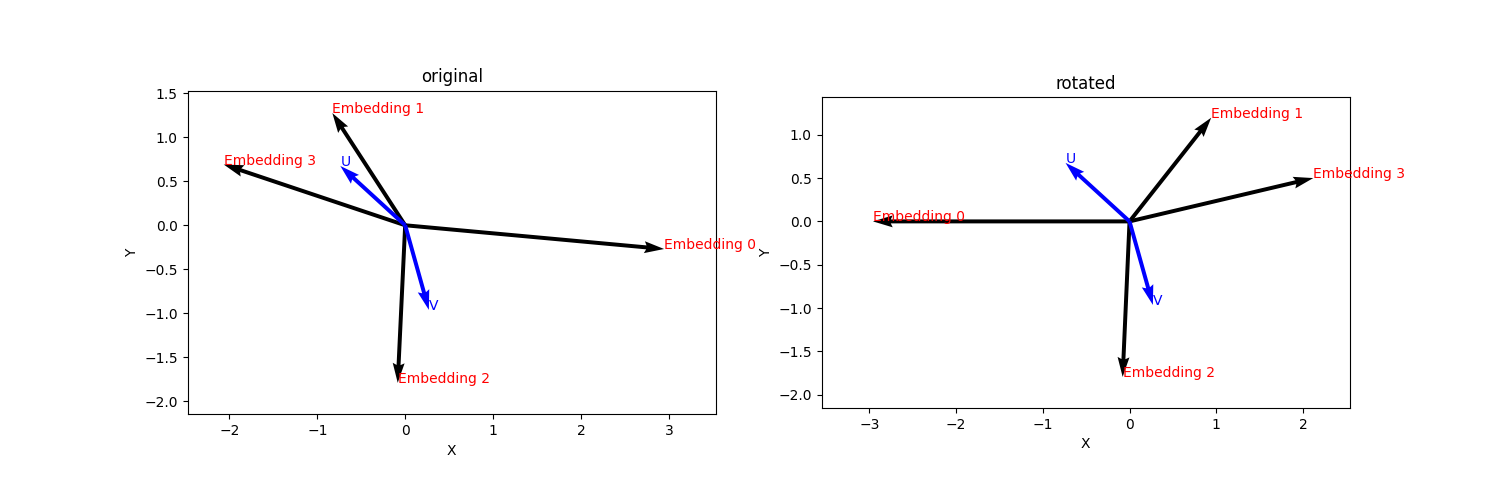

In [20]:
import matplotlib.pyplot as plt
import numpy as n

%matplotlib widget

plt.close('all')

def plot_tensor(fig, tensor, position = 111, title = ""):
    ax = fig.add_subplot(position)
    ax.set_title(title)

    # Define the origin
    origin = np.zeros((4, 2))

    # Plot the arrows
    for i in range(tensor.shape[0]):
        ax.quiver(origin[i, 0], origin[i, 1], 
                tensor[i, 0], tensor[i, 1],
                angles='xy', scale_units='xy', scale=1)

        ax.text(tensor[i, 0], tensor[i, 1], f"Embedding {i}", color='red')
    W_Q = model.blocks[0].attn.W_Q.data[0]
    W_K = model.blocks[0].attn.W_K.data[0].transpose(0, 1)
    W_QK = torch.matmul(W_Q, W_K)
    U, S, V = np.linalg.svd(W_QK.cpu())
    print("U=", U, "\nS=", S, "\nV=", V)
    
    ax.quiver(origin[i, 0], origin[i, 1], U[0, 0], U[0, 1], angles='xy', scale_units='xy', scale=1, color='blue')
    ax.text(U[0, 0], U[0, 1], f"U", color='blue')
    ax.quiver(origin[i, 0], origin[i, 1], V[0, 0], V[0, 1], angles='xy', scale_units='xy', scale=1, color='blue')
    ax.text(V[0, 0], V[0, 1], f"V", color='blue')

    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_xlim(min(tensor[:, 0].min(), 0)*1.2, max(tensor[:, 0].max(), 0) * 1.2)
    ax.set_aspect('equal')
    ax.set_ylim(min(tensor[:, 1].min(), 0)*1.2, max(tensor[:, 1].max(), 0) * 1.2)

fig = plt.figure(figsize=(15, 5))
plot_tensor(fig, W_E, 121, "original")
plot_tensor(fig, R.transpose(), 122, "rotated")
plt.show()

# Unembedding weights

In [21]:
W_U = model.unembed.W_U.data.cpu().numpy()

print(W_U)

Qrev, Rrev = qr(W_U)

print("Q_U=", Qrev)
print("R_U=", Rrev)

print("W_E=", W_E)
print("W_U=", W_U)

product = np.matmul(W_E, W_U)
print(product)

rank = np.linalg.matrix_rank(product)
print(rank)

[[ 0.9159276  -1.1328202   0.69533354]
 [ 1.7992926   0.22373027 -1.3513923 ]]
Q_U= [[-0.45365322 -0.89117837]
 [-0.89117837  0.45365316]]
R_U= [[-2.0190039   0.31452394  0.8888912 ]
 [ 0.          1.1110408  -1.2327296 ]]
W_E= [[ 2.9465358  -0.27007568]
 [-0.8285537   1.2766306 ]
 [-0.08472562 -1.7930963 ]
 [-2.0640135   0.6907403 ]]
W_U= [[ 0.9159276  -1.1328202   0.69533354]
 [ 1.7992926   0.22373027 -1.3513923 ]]
[[ 2.2128682  -3.3983195   2.4138036 ]
 [ 1.538137    1.2242233  -2.3013499 ]
 [-3.3039074  -0.30519104  2.364264  ]
 [-0.64764297  2.4926958  -2.368639  ]]
2


# Activations

In [22]:
input = torch.tensor([[0,3], [1,3], [2,3]])
logits, cache = model.run_with_cache(input)
print(logits)

tensor([[[13.5004, -7.9870,  0.5846],
         [10.6316, -2.0914, -4.1978]],

        [[ 2.1089,  7.1756, -9.2545],
         [-4.8386,  7.8999, -5.7986]],

        [[-9.2451, -7.1642, 13.6171],
         [-6.5888, -4.3657,  8.8835]]], device='cuda:0',
       grad_fn=<AddBackward0>)


In [23]:
W_K = model.blocks[0].attn.W_K.data[0].cpu()
W_Q = model.blocks[0].attn.W_Q.data[0].cpu()
print("W_K: ", W_K)
W_K_T = torch.transpose(W_K, 0, 1)
W_QK = torch.matmul(W_Q, W_K_T)
print("W_Q: ", W_Q)
print("W_K transposed: ", W_K_T)
print(W_QK)
W_V = model.blocks[0].attn.W_V.data[0].cpu()
W_O = model.blocks[0].attn.W_O.data[0].cpu()
W_VO = torch.matmul(W_V, W_O)
print(W_VO)
W_E = model.embed.W_E.data.cpu().numpy()
U, S, V = np.linalg.svd(W_QK)
print("U: ", U)
print("S: ", S)
print("V: ", V)
S_rank_1 = np.zeros((2, 2))
S_rank_1[0, 0] = S[0]
print("S_rank_1: ", S_rank_1)
W_QK_rank_1 = np.matmul(np.matmul(U, S_rank_1), V)
print("W_QK_rank_1: ", W_QK_rank_1)

W_K:  tensor([[ 5.1414e-01,  1.1962e-03],
        [-1.8203e+00, -6.0450e-02]])
W_Q:  tensor([[-0.9116, -0.8793],
        [ 0.8709, -0.3900]])
W_K transposed:  tensor([[ 5.1414e-01, -1.8203e+00],
        [ 1.1962e-03, -6.0450e-02]])
tensor([[-0.4698,  1.7126],
        [ 0.4473, -1.5618]])
tensor([[ 1.3743,  1.5883],
        [-2.8028,  3.1601]])
U:  [[-0.73782986  0.6749867 ]
 [ 0.6749867   0.73782986]]
S:  [2.406839   0.01346607]
V:  [[ 0.26945356 -0.9630134 ]
 [ 0.9630134   0.26945356]]
S_rank_1:  [[2.40683889 0.        ]
 [0.         0.        ]]
W_QK_rank_1:  [[-0.47850576  1.71015544]
 [ 0.43775001 -1.56449646]]


In [24]:
cache.cache_dict

{'hook_embed': tensor([[[ 1.9919,  0.6364],
          [-1.0032, -0.0141]],
 
         [[-1.7832,  2.1832],
          [-1.0032, -0.0141]],
 
         [[-1.0393, -0.8866],
          [-1.0032, -0.0141]]], device='cuda:0'),
 'hook_pos_embed': tensor([[[ 0.9546, -0.9065],
          [-1.0608,  0.7049]],
 
         [[ 0.9546, -0.9065],
          [-1.0608,  0.7049]],
 
         [[ 0.9546, -0.9065],
          [-1.0608,  0.7049]]], device='cuda:0'),
 'blocks.0.hook_resid_pre': tensor([[[ 2.9465, -0.2701],
          [-2.0640,  0.6907]],
 
         [[-0.8286,  1.2766],
          [-2.0640,  0.6907]],
 
         [[-0.0847, -1.7931],
          [-2.0640,  0.6907]]], device='cuda:0'),
 'blocks.0.attn.hook_q': tensor([[[[-2.9213, -2.4856]],
 
          [[ 2.4832,  1.5455]]],
 
 
         [[[ 1.8672,  0.2306]],
 
          [[ 2.4832,  1.5455]]],
 
 
         [[[-1.4844,  0.7739]],
 
          [[ 2.4832,  1.5455]]]], device='cuda:0'),
 'blocks.0.attn.hook_k': tensor([[[[ 2.0066,  0.0199]],
 
          [[-

# Animations

In [25]:
from manim import *

config.media_width = "80%"
config.verbosity = "WARNING"
config.preview = False

In [26]:
class VectorParams:
    def __init__(self, values = [], color = WHITE):
        self.values = values
        self.color = color
    def __repr__(self) -> str:
        return str(self.values) + "(" + str(self.color) + ")"

class Data:
    def __init__(self):
        self.vectors: list[list[VectorParams]] = [[]]
        self.steps = 0

    def add_vector(self, vector, color = WHITE):
        self.vectors[self.steps].append(VectorParams(values = vector, color = color))

    def next_step(self):
        self.steps += 1
        self.vectors.append([])

    def add_vectors_at_hook(self, c: ActivationCache, hook: str, color0 = WHITE, color1 = WHITE):
        for i in range(3):
            self.add_vector(c.cache_dict[hook][i][0].cpu(), color = color0)
            self.add_vector(c.cache_dict[hook][i][1].cpu(), color = color1)


vectors = Data()
vectors.add_vectors_at_hook(cache, "hook_embed", color1 = GRAY)
vectors.next_step()
vectors.add_vectors_at_hook(cache, "blocks.0.hook_resid_pre")
vectors.next_step()
vectors.add_vectors_at_hook(cache, "blocks.0.hook_resid_mid", color0 = GRAY)
#vectors.add_vectors_at_hook(cache, "blocks.0.hook_resid_post")

print(vectors.vectors)

[[tensor([1.9919, 0.6364])(#FFFFFF), tensor([-1.0032, -0.0141])(#888888), tensor([-1.7832,  2.1832])(#FFFFFF), tensor([-1.0032, -0.0141])(#888888), tensor([-1.0393, -0.8866])(#FFFFFF), tensor([-1.0032, -0.0141])(#888888)], [tensor([ 2.9465, -0.2701])(#FFFFFF), tensor([-2.0640,  0.6907])(#FFFFFF), tensor([-0.8286,  1.2766])(#FFFFFF), tensor([-2.0640,  0.6907])(#FFFFFF), tensor([-0.0847, -1.7931])(#FFFFFF), tensor([-2.0640,  0.6907])(#FFFFFF)], [tensor([7.7529, 3.5565])(#888888), tensor([2.7379, 4.5150])(#FFFFFF), tensor([-5.5453,  3.9949])(#888888), tensor([-6.8192,  0.7821])(#FFFFFF), tensor([ 4.8244, -7.5940])(#888888), tensor([ 2.8447, -5.1100])(#FFFFFF)]]


In [27]:
def change_font_size(labeled_arrow: LabeledArrow, new_size):
    # print(labeled_arrow, labeled_arrow.submobjects)
    # print(labeled_arrow.submobjects[-1].font_size)
    if not isinstance(labeled_arrow, LabeledArrow):
        return
    label = labeled_arrow.submobjects[-1]
    box = labeled_arrow.submobjects[-2]
    if not isinstance(box, BackgroundRectangle):
        box = labeled_arrow.submobjects[-3]
    coords = label.get_center()
    # print(new_size)
    labeled_arrow.submobjects[-1] = MathTex(
        label.get_tex_string(), color=label.color, font_size=new_size
    )
    # print("size=", labeled_arrow.submobjects[-1].font_size)
    label = labeled_arrow.submobjects[-1]
    label.move_to(coords)
    box.width = label.width + 2 * box.buff
    box.height = label.height + 2 * box.buff

In [28]:
class VisualizeTransformer(MovingCameraScene):
    def construct(self):
        print("v=", vectors.vectors)
        axes = Axes(
            x_range = [-20, 20, 1],
            y_range = [-20, 20, 1],
            x_axis_config={
                "numbers_to_include": np.arange(-18, 18.1, 3),
                "font_size": 24
            },
            y_axis_config={
                "numbers_to_include": np.arange(-18, 18.1, 3), 
                "font_size": 24            
            },
            x_length = 40,
            y_length = 40,
            axis_config={"color": GREEN}
        )
        axes_labels = axes.get_axis_labels()

        scale = ValueTracker(2)

        arrows = VGroup()
        def update_scale(self):
            self.stroke_width = 6 * scale.get_value()
            change_font_size(self, 48 * scale.get_value())
            # print("New font size: ", self.font_size)

        # Embedding arrows
        for i, t in enumerate(vectors.vectors[0]):
            # print(t, t.numpy())
            arrow = LabeledArrow(
                start=ORIGIN,
                end=np.append(t.values.numpy(), 0),
                buff = 0,
                label = str(i//2) if i%2==0 else str(i//2) + "=",
                label_frame = False,
                label_color=YELLOW,
                color = t.color,
                max_stroke_width_to_length_ratio = 100,
            )

            arrow.add_updater(update_scale)
            arrows.add(arrow)

        # Transitioing the arrows through the model
        self.add(axes, axes.get_axis_labels(), arrows)
        for step in range(1, len(vectors.vectors)):
            new_arrows = VGroup()
            transition_arrows = VGroup()
            for i, t in enumerate(vectors.vectors[step]):
                # print(t, t.numpy())
                new_arrow = LabeledArrow(
                    start=ORIGIN,
                    end=np.append(t.values.numpy(), 0),
                    buff=0,
                    label=str(i // 2) if i % 2 == 0 else str(i // 2) + "=",
                    label_frame=False,
                    label_color=YELLOW,
                    color=t.color,
                    max_stroke_width_to_length_ratio=100,
                )
                new_arrow.add_updater(update_scale)
                new_arrows.add(new_arrow)
                transition_arrow = Arrow(
                    start=arrows[i].end, end=new_arrows[i].end, buff=0, color=RED
                )
                transition_arrow.add_updater(update_scale)
                transition_arrows.add(transition_arrow)

            view = SurroundingRectangle(new_arrows)
            factor = max(
                view.width / self.camera.frame_width,
                view.height / self.camera.frame_height,
            )
            print(
                factor,
                self.camera.frame_width, view.width,
                self.camera.frame_height, view.height,
            )
            self.wait()
            self.play(FadeIn(transition_arrows), self.camera.auto_zoom(view, margin = 2), scale.animate.set_value(scale.get_value() * factor))
            self.wait()
            self.play(
                ReplacementTransform(arrows, new_arrows)
            )
            self.wait()
            self.play(FadeOut(transition_arrows))
            self.wait()
            arrows = new_arrows

        # Unembedding Arrows
        embedding_arrows = VGroup()
        data = model.W_U.data
        for i in range(model.W_U.data.size()[1]):
            embedding_arrow = LabeledArrow(
                start=ORIGIN,
                end=[data[0, i].item(), data[1, i].item(), 0],
                label=str(i),
                color=BLUE,
            )
            embedding_arrows.add(embedding_arrow)
        self.play(FadeIn(embedding_arrows))
        self.wait()

# v = VisualizeTransformer()
# v.construct()

In [29]:
%%manim -ql -p Video

class Video(VisualizeTransformer):
    def construct(self):
        VisualizeTransformer.construct(self)

Manim Community v0.18.1

v= [[tensor([1.9919, 0.6364])(#FFFFFF), tensor([-1.0032, -0.0141])(#888888), tensor([-1.7832,  2.1832])(#FFFFFF), tensor([-1.0032, -0.0141])(#888888), tensor([-1.0393, -0.8866])(#FFFFFF), tensor([-1.0032, -0.0141])(#888888)], [tensor([ 2.9465, -0.2701])(#FFFFFF), tensor([-2.0640,  0.6907])(#FFFFFF), tensor([-0.8286,  1.2766])(#FFFFFF), tensor([-2.0640,  0.6907])(#FFFFFF), tensor([-0.0847, -1.7931])(#FFFFFF), tensor([-2.0640,  0.6907])(#FFFFFF)], [tensor([7.7529, 3.5565])(#888888), tensor([2.7379, 4.5150])(#FFFFFF), tensor([-5.5453,  3.9949])(#888888), tensor([-6.8192,  0.7821])(#FFFFFF), tensor([ 4.8244, -7.5940])(#888888), tensor([ 2.8447, -5.1100])(#FFFFFF)]]
0.4090351772680879 14.222222222222221 5.210549306869507 7.993754879000781 3.2697269439697267


2.3358097092767744 9.375722521146137 14.772139263153075 5.269726943969727 12.309079360961913


[0000581fa8bc5640] main libvlc: VLC wird mit dem Standard-Interface ausgeführt. Benutzen Sie 'cvlc', um VLC ohne Interface zu verwenden.


[00007ce6b0004930] gl gl: Initialized libplacebo v4.192.1 (API v192)
libva info: VA-API version 1.20.0
libva error: vaGetDriverNames() failed with unknown libva error
[00007ce6b0004930] glconv_vaapi_x11 gl error: vaInitialize: unknown libva error
libva info: VA-API version 1.20.0
libva info: Trying to open /usr/lib/x86_64-linux-gnu/dri/nvidia_drv_video.so
libva info: va_openDriver() returns -1
[00007ce6b0004930] glconv_vaapi_drm gl error: vaInitialize: unknown libva error
libva info: VA-API version 1.20.0
libva info: Trying to open /usr/lib/x86_64-linux-gnu/dri/iHD_drv_video.so
libva info: Found init function __vaDriverInit_1_19
libva info: va_openDriver() returns 0
[00007ce6b4048920] main video output error: video output creation failed
[00007ce6c0c1b4a0] main decoder error: failed to create video output
[00007ce6b052f860] gl gl: Initialized libplacebo v4.192.1 (API v192)
[00007ce6c0c1b4a0] avcodec decoder: Using NVIDIA VDPAU Driver Shared Library  550.90.12  Thu Aug 29 05:29:07 UTC 2